In [2]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [3]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

In [4]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

products_spec = importlib.util.spec_from_file_location('products', '../scripts/products.py')
products = importlib.util.module_from_spec(products_spec)
products_spec.loader.exec_module(products)

# Cymetric

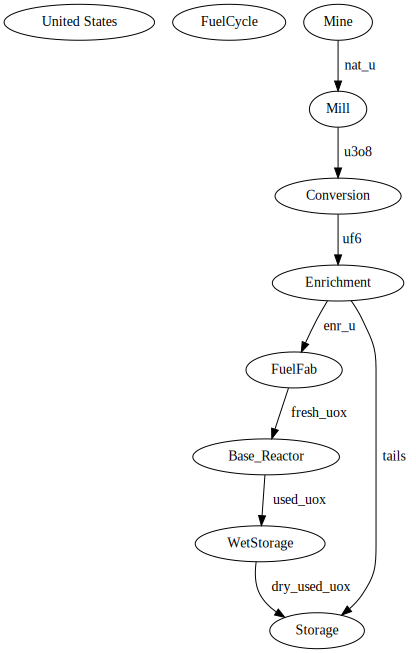

In [5]:
file = 'base_reactor_out.sqlite'
conn = sqlite3.connect(file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

db = cym.dbopen(file)
evaler = cym.Evaluator(db, write=False)
graphs.flow_graph(evaler, label='com')

In [6]:
reactor_list = ['Base_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

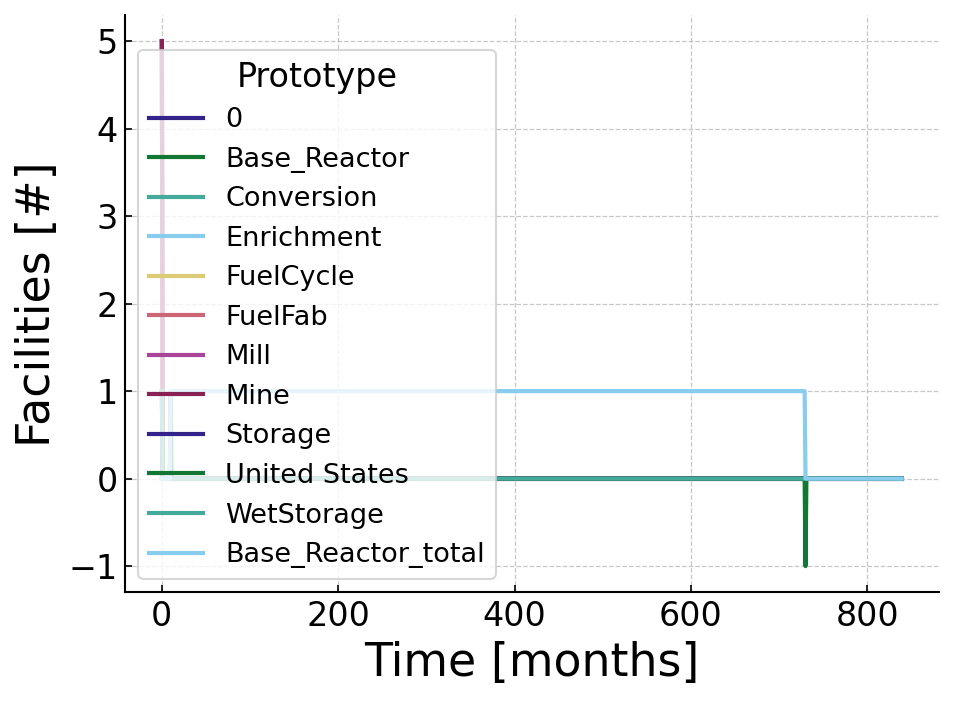

In [7]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

Text(0, 0.5, 'Reactors [#]')

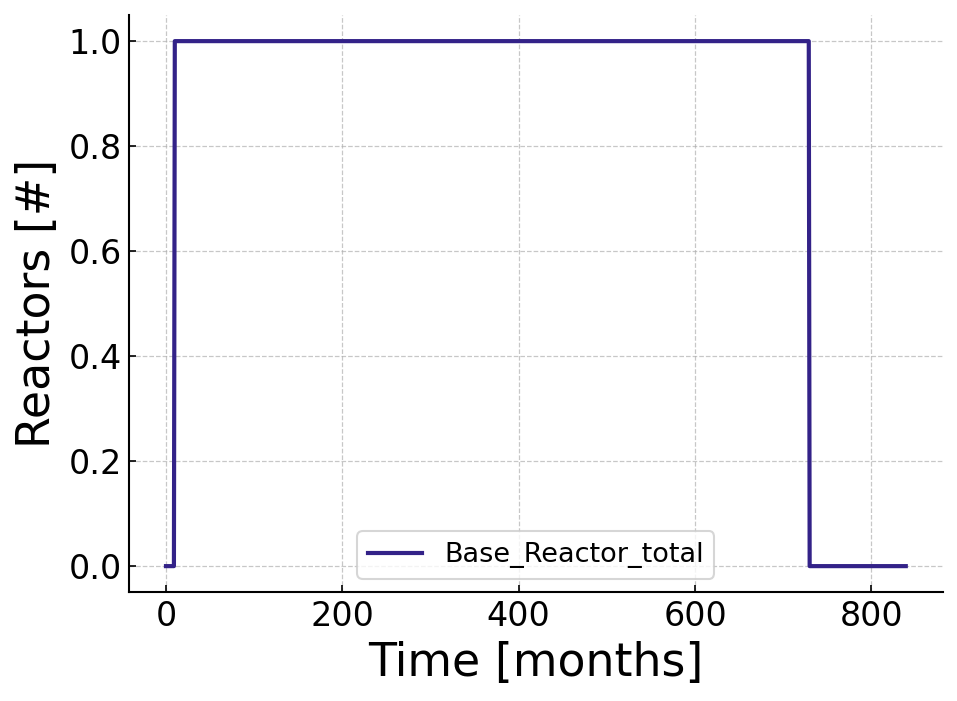

In [8]:
deployment_by_prototype.plot(y='Base_Reactor_total', use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

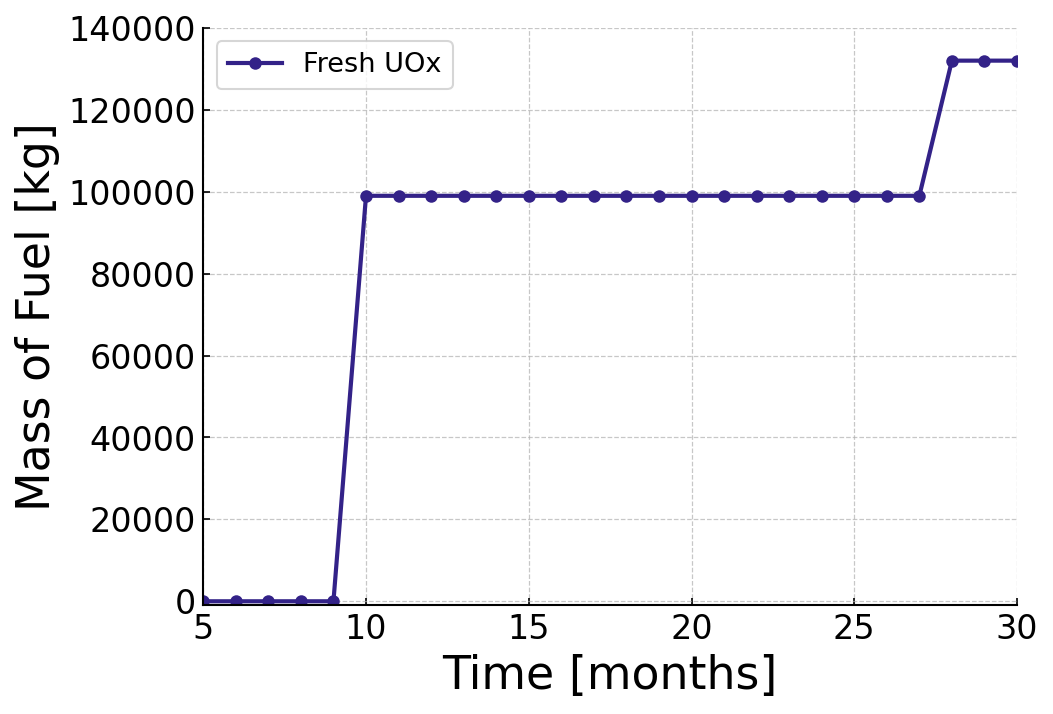

In [10]:
fuels = ['fresh_uox']
receivers = ['Base_Reactor']

reactor_received = tran.fuel_received(evaler, fuels, receivers)

reactor_received[['Time','fresh_uox_Base_Reactor_total']].plot(x='Time', style=['-o'])

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
plt.xlim(5,30)
plt.ylim(-1000,140000)
legend = plt.legend()
legend.get_texts()[0].set_text('Fresh UOx')


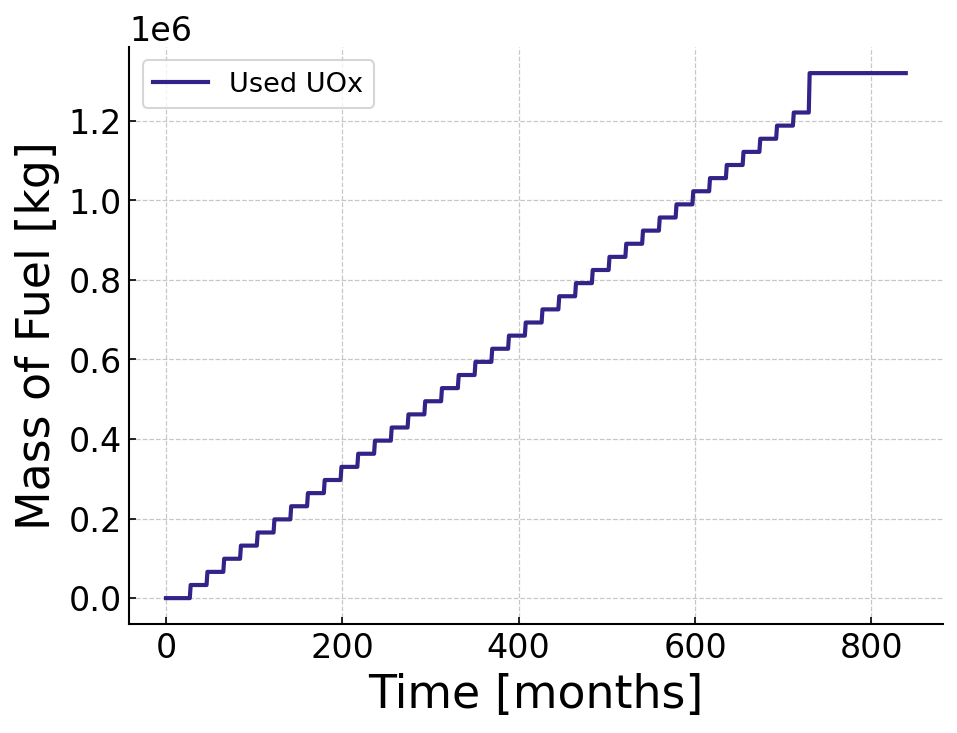

In [18]:
sent_fuels = ['used_uox']
reactor_sent = tran.fuel_sent(evaler, sent_fuels, receivers)

reactor_sent[['Time','used_uox_Base_Reactor_total']].plot(x='Time')

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
legend = plt.legend()
legend.get_texts()[0].set_text('Used UOx')


In [10]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox']

transactions = tran.used_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_used_fr_fuel(transactions, fuels)

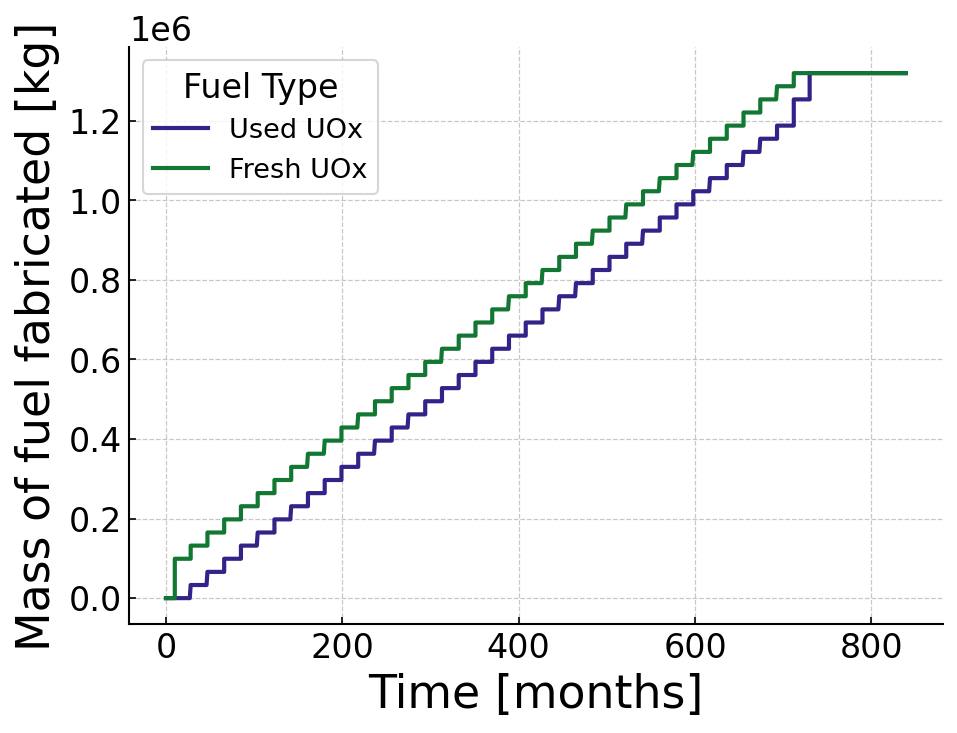

In [11]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'used_uox_total', 'fresh_uox_total']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel fabricated [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Used UOx')
legend.get_texts()[1].set_text('Fresh UOx')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

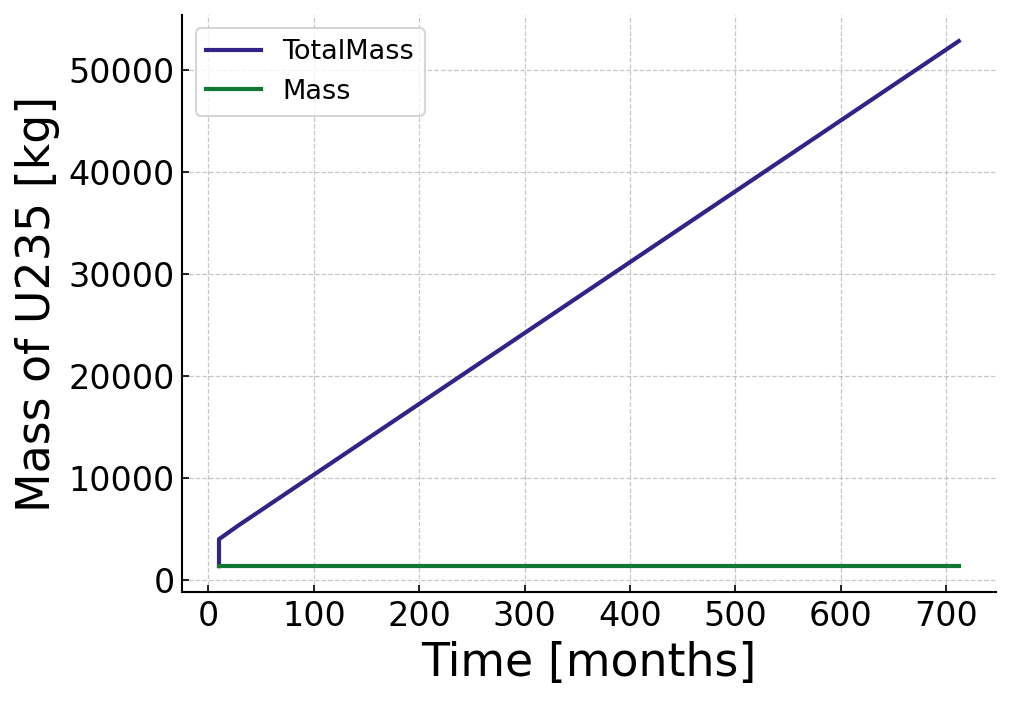

In [12]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

Text(0, 0.5, 'Mass of Pu239 [kg]')

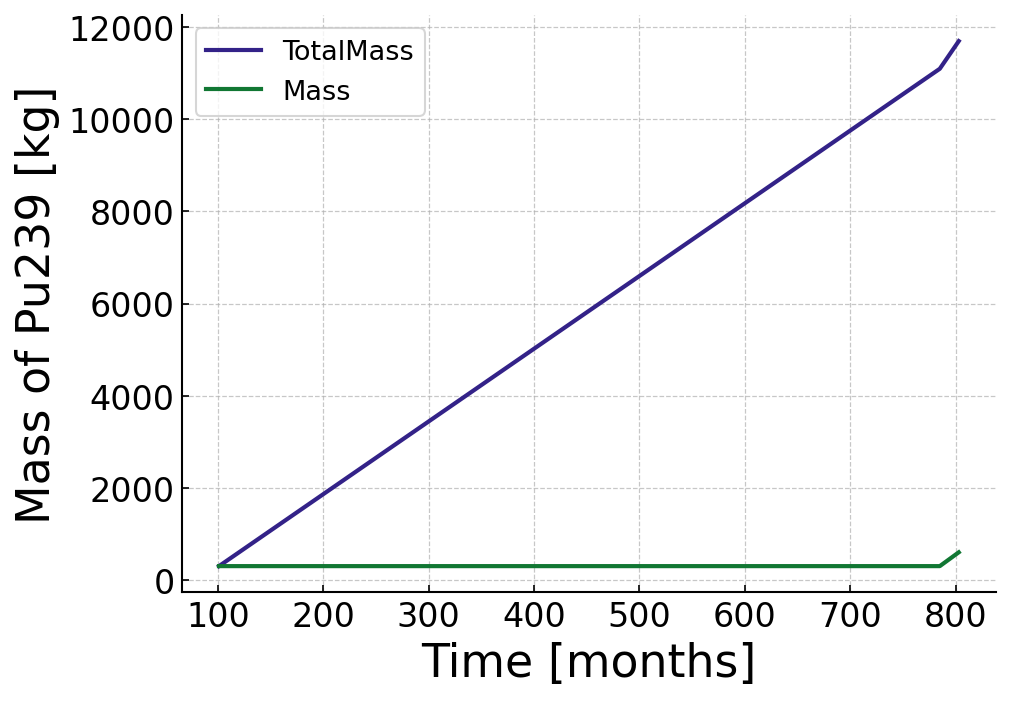

In [13]:
Pu239_mass = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['dry_used_uox'], nucs=['94239'])

Pu239_mass['TotalMass'] = Pu239_mass['Mass'].cumsum()
Pu239_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of Pu239 [kg]')

In [14]:
all_isotopes = ['551370000', '922350000', '922380000', '942390000']

commodities = ['used_uox', 'tails']
receivers = ['Storage']

isotope_db = waste.isotope_database(evaler=evaler,receivers=receivers, commodities=commodities, isotopes=all_isotopes)

/home/nsryan/Desktop/ornl/NEAR/baseline/../scripts/waste.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8655.26315789474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_df.loc[str(time_step),str(nucid)] = mass
/home/nsryan/Desktop/ornl/NEAR/baseline/../scripts/waste.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4318976.315789474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_df.loc[str(time_step),str(nucid)] = mass


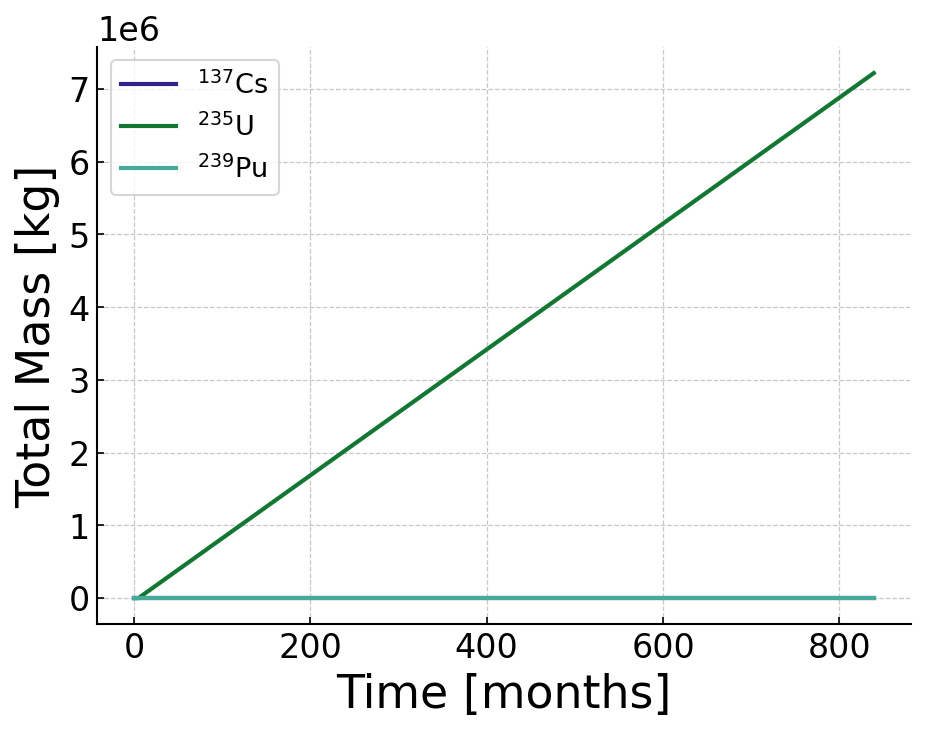

In [15]:
isotope_db[['Time','551370000_total','922350000_total','942390000_total']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Total Mass [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text(f'$^{{137}}$Cs')
legend.get_texts()[1].set_text(f'$^{{235}}$U')
legend.get_texts()[2].set_text(f'$^{{239}}$Pu')

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [16]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 730, 730)


In [17]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 25, 'Base_Reactor', 0, 10)


## Energy Production

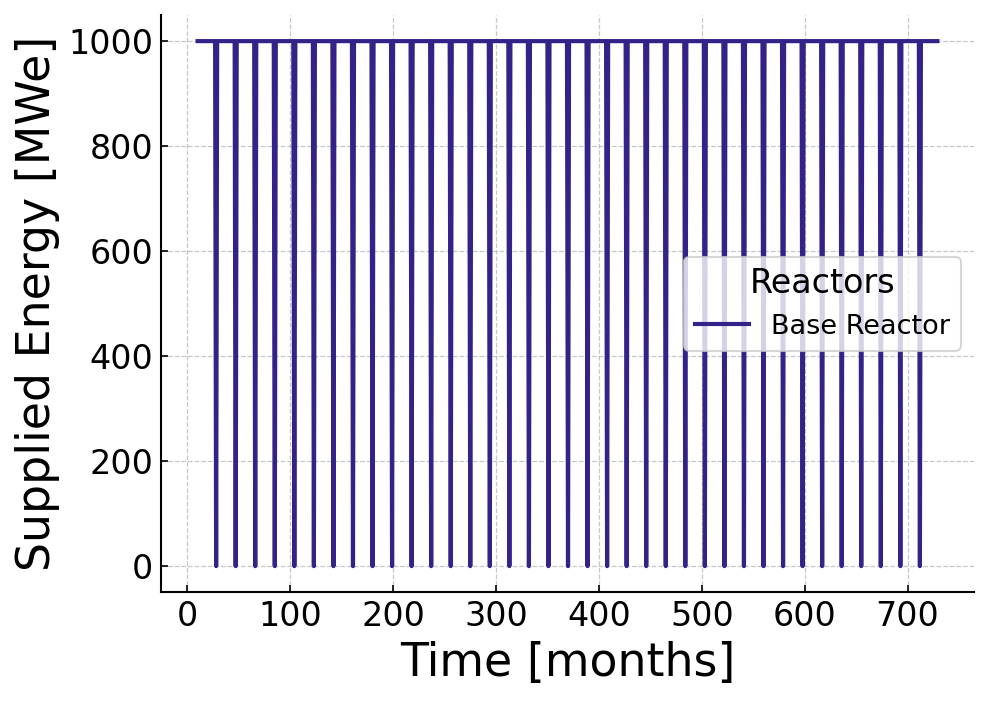

In [18]:
power_supply = products.energy_supply(cursor)

power_supply[['53']].plot()
#switch_energy_supply[['53','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
#legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

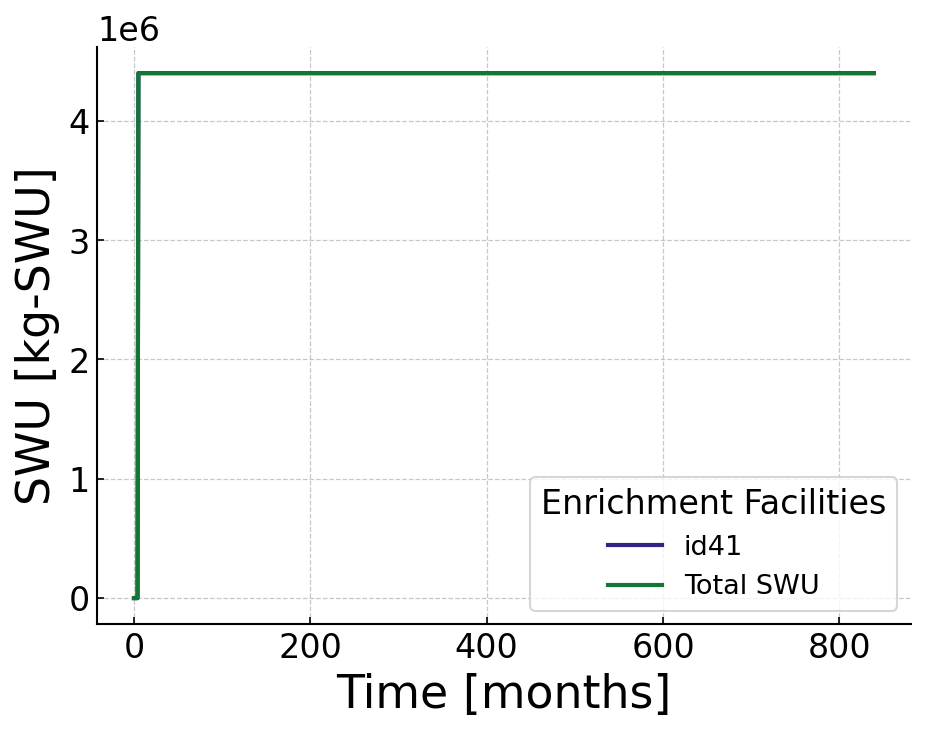

In [19]:
switch_swu_supply = products.swu_supply(cursor)

switch_swu_supply[['41','total_swu']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id41')
legend.get_texts()[1].set_text('Total SWU')
legend.set_title('Enrichment Facilities')

# Graveyard

In [20]:
cursor.execute("SELECT * FROM TimeSeriesPower")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 10, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 11, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 12, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 13, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 14, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 15, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 16, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 17, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 18, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 19, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 20, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 21, 1000.0, '')
(b'\xce\xd5\xd9\x9b\x93mAR\x

In [21]:
cursor.execute("SELECT * FROM AgentStateInventories")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 41, 840, 'inventory', 87293)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 41, 840, 'tails', 87594)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'processing', 87590)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'processing', 87592)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'processing', 87597)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'processing', 87599)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'processing', 87601)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 31, 840, 'stocks', 87605)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 46, 840, 'processing', 87595)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 46, 840, 'stocks', 74376)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 46, 840, 'stocks', 4409)
(b'\xce\xd5\xd9\x9

In [22]:
cursor.execute("SELECT * FROM Prototypes")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Mine', 14, ':cycamore:Source')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Mill', 15, ':cycamore:Storage')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Conversion', 16, ':cycamore:Storage')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Enrichment', 17, ':cycamore:Enrichment')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'FuelFab', 18, ':cycamore:Storage')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Base_Reactor', 19, ':cycamore:Reactor')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'WetStorage', 20, ':cycamore:Storage')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'Storage', 21, ':cycamore:Sink')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'FuelCycle', 22, ':cycamore:DeployInst')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 'United States', 23, ':agents:NullRegion')


In [23]:
cursor.execute("SELECT * FROM ReactorEvents")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 10, 'LOAD', '3 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 10, 'CYCLE_START', '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 28, 'TRANSMUTE', '1 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 28, 'CYCLE_END', '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 28, 'DISCHARGE', '1 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 28, 'LOAD', '1 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 29, 'CYCLE_START', '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 47, 'TRANSMUTE', '1 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 47, 'CYCLE_END', '')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 47, 'DISCHARGE', '1 assemblies')
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 53, 47, 'LOAD

In [24]:
cursor.execute("SELECT * FROM FieldTypes")
rows = cursor.fetchall()

for row in rows:
    print(row)

('InputFiles', 'SimId', 7)
('InputFiles', 'Data', 6)
('Info', 'SimId', 7)
('Info', 'Handle', 4)
('Info', 'InitialYear', 1)
('Info', 'InitialMonth', 1)
('Info', 'Duration', 1)
('Info', 'Seed', 1)
('Info', 'Stride', 1)
('Info', 'ParentSimId', 7)
('Info', 'ParentType', 4)
('Info', 'BranchTime', 1)
('Info', 'CyclusVersion', 4)
('Info', 'CyclusVersionDescribe', 4)
('Info', 'SqliteVersion', 4)
('Info', 'Hdf5Version', 4)
('Info', 'BoostVersion', 4)
('Info', 'LibXML2Version', 4)
('Info', 'CoinCBCVersion', 4)
('DecayMode', 'SimId', 7)
('DecayMode', 'Decay', 4)
('InfoExplicitInv', 'SimId', 7)
('InfoExplicitInv', 'RecordInventory', 0)
('InfoExplicitInv', 'RecordInventoryCompact', 0)
('TimeStepDur', 'SimId', 7)
('TimeStepDur', 'DurationSecs', 1)
('Epsilon', 'SimId', 7)
('Epsilon', 'GenericEpsilon', 3)
('Epsilon', 'ResourceEpsilon', 3)
('XMLPPInfo', 'SimId', 7)
('XMLPPInfo', 'LibXMLPlusPlusVersion', 4)
('SolverInfo', 'SimId', 7)
('SolverInfo', 'Solver', 4)
('SolverInfo', 'ExclusiveOrders', 0)
('Gre

In [25]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [26]:
cursor.execute("SELECT * FROM InfoExplicitInv")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 0)


In [27]:
cursor.execute("SELECT * FROM NextIds")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'Agent', 53)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'Transaction', 0)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'Composition', 23)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'ResourceState', 1)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'ResourceObj', 1)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 0, 'Product', 1)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'Agent', 54)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'Transaction', 7661)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'Composition', 5877)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'ResourceState', 87606)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'ResourceObj', 78219)
(b'\xce\xd5\xd9\x9b\x93mAR\x80\xb1\xd2\xc5\xf5\xef\x9c\x98', 840, 'Product', 1)


In [28]:
columns

[('FieldTypes',),
 ('InputFiles',),
 ('Info',),
 ('DecayMode',),
 ('InfoExplicitInv',),
 ('TimeStepDur',),
 ('Epsilon',),
 ('XMLPPInfo',),
 ('SolverInfo',),
 ('GreedySolverInfo',),
 ('Compositions',),
 ('Recipes',),
 ('AgentStateAgent',),
 ('AgentState_cycamore_SourceInfo',),
 ('AgentPosition',),
 ('Prototypes',),
 ('AgentVersions',),
 ('AgentState_cycamore_StorageInfo',),
 ('AgentState_cycamore_EnrichmentInfo',),
 ('AgentState_cycamore_ReactorInfo',),
 ('AgentState_cycamore_SinkInfo',),
 ('AgentState_cycamore_DeployInstInfo',),
 ('AgentState_agents_NullRegionInfo',),
 ('AgentEntry',),
 ('BuildSchedule',),
 ('Snapshots',),
 ('NextIds',),
 ('TimeSeriesdemandtails',),
 ('TimeSeriesdemanddry_used_uox',),
 ('TimeSeriessupplynat_u',),
 ('TimeSeriessupplytails',),
 ('TimeSeriessupplyenr_u',),
 ('Resources',),
 ('MaterialInfo',),
 ('ResCreators',),
 ('Transactions',),
 ('TimeSeriesdemandnat_u',),
 ('TimeSeriessupplyu3o8',),
 ('TimeSeriesdemandu3o8',),
 ('TimeSeriessupplyuf6',),
 ('TimeSeriesE

In [29]:


# we'll make an empty dataframe based on this range, which we'll overwrite with the existing data
#simulation_energy_supply = pd.DataFrame(index=dates, columns=switch_energy_supply.columns)

# now we will combine the
#switch_energy_supply = switch_energy_supply.reindex(simulation_energy_supply.index)

#for col in switch_energy_supply.columns:
#    simulation_energy_supply[col] = switch_energy_supply[col].copy()

# now we can fill the missing values with 0 instead of NaN
#simulation_energy_supply = simulation_energy_supply.fillna(0)